In [1]:
import os
import pandas as pd
import fathon
from fathon import fathonUtils as fu
import numpy as np
from collections import defaultdict

In [2]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

import sys
sys.path.insert(0, '/directory/tothe/handshakefile/')
sys.path.append('/home/ak/Documents/PaperCode/stylised_facts')
import stylised_facts_data_utilities as sfd_utils
import lob_for_futures as lobfut
import mdfda.mdfda_experiments_utils as mdf
%matplotlib inline
import os
figuresLocation = '/home/ak/Documents/Papers/StylisedFactsPaper/figures' # location to store the figures

In [13]:
activityClockData = '/media/ak/My Passport/ExperimentData/ActivityClockData' # this is an old set of files that has activity clock data
autoCorrelFolder = os.path.join(activityClockData, 'AutoCorrel') # auto-correlation files we have to discuss
clocksData = [f for f in os.listdir(activityClockData) if str('Clocks') in f] # all symbolls and all clocksData
keys = ['OriginalDF', 'TickBarDf', 'VolumeBarDf', 'DollarVolumeBarDf']

In [27]:
# each clockData file Looks like this
pd.read_pickle(os.path.join(activityClockData, clocksData[0]))['OriginalDF'].head(4)


,BidQuoteId,BidSize,QuoteTime,type_x,BestBid,TradeTime,AskQuoteId,AskSize,time_y,type_y,BestAsk,TradeId,TradeVolume,TradedTime,type,TradePrice,TradeId,TimeStamp,milliSeconds,DollarVolume,MicroPrice,TradeSize,DollarVolumeTraded
0,0,130,2018-04-18 00:00:00,BID,113.929688,2018-04-18,16,426,2018-04-18 00:00:00,ASK,113.9375,NaN,0.0,NaN,NaN,NaN,NaN,00:00:00,0,NaN,113.935673,0.0,NaN
1,5,193,2018-04-18 00:00:00,BID,113.929688,2018-04-18,16,426,2018-04-18 00:00:00,ASK,113.9375,NaN,0.0,NaN,NaN,NaN,NaN,00:00:00,0,NaN,113.935064,0.0,NaN
2,7,204,2018-04-18 00:00:00,BID,113.929688,2018-04-18,16,426,2018-04-18 00:00:00,ASK,113.9375,NaN,0.0,NaN,NaN,NaN,NaN,00:00:00,0,NaN,113.934970,0.0,NaN
3,6,203,2018-04-18 00:00:00,BID,113.929688,2018-04-18,16,426,2018-04-18 00:00:00,ASK,113.9375,NaN,0.0,NaN,NaN,NaN,NaN,00:00:00,0,NaN,113.934979,0.0,NaN


In [71]:
list(np.unique([f[1].split("Data_")[1].split('_Comd')[0] for f in enumerate(os.listdir(autoCorrelFolder))]))

['DU1', 'FB1', 'FV1', 'G_1', 'JB1']

In [157]:
symbol ='JB1'
symbolFiles = [f for f in os.listdir(autoCorrelFolder) if str(symbol) in f] # we chose a symbol and pick one set of files

In [158]:
# 3 types of auto-correlation files here  / Volume / Tick and Dollar Volume
correlVolumeClock =list(np.sort([s for s in symbolFiles if ('AtoCor') in s and ('1AtoCorrelData') in s]))
correlTickClock =list(np.sort([s for s in symbolFiles if ('AtoCor') in s and ('0AtoCorrelData') in s]))
correlDollarVolumeClock =list(np.sort([s for s in symbolFiles if ('AtoCor') in s and ('2AtoCorrelData') in s]))


In [159]:
length_of_files = len(correlTickClock) # length of each file 

In [160]:
appended_data_volume_clock= [] # produce 3 lists as you iterate across all files- not very elegant
appended_data_tick_clock= []
appended_data_dollar_volume_clock= []

for idx in range(0,len(correlVolumeClock)): # presumably the assumption here is that all files have the same length
    fileIdx_volume_clock = os.path.join( autoCorrelFolder, correlVolumeClock[idx])
    fileIdx_dollar_clock = os.path.join( autoCorrelFolder, correlDollarVolumeClock[idx])
    fileIdx_tick_clock = os.path.join( autoCorrelFolder, correlTickClock[idx])
    
    appended_data_volume_clock.append(pd.DataFrame(pd.read_pickle(fileIdx_volume_clock ).values()))
    appended_data_tick_clock.append(pd.DataFrame(pd.read_pickle(fileIdx_tick_clock ).values()))
    appended_data_dollar_volume_clock.append(pd.DataFrame(pd.read_pickle(fileIdx_dollar_clock ).values()))
    
    

In [161]:
appended_df_volume = pd.concat(appended_data_volume_clock, axis=1) # concatenate all the files into one dataframe
appended_df_tick = pd.concat(appended_data_tick_clock, axis=1)
appended_df_dollar_volume = pd.concat(appended_data_dollar_volume_clock, axis=1)


In [162]:
title_tick = str(symbol) + '_all_autocorrelation_tick_appended.csv'
location_tick = os.path.join(activityClockData, title_tick)
appended_df_tick.to_csv(location_tick)

In [163]:
title_volume = str(symbol) + '_all_autocorrelation_volume_appended.csv'
location_volume = os.path.join(activityClockData, title_volume)
appended_df_volume.to_csv(location_volume)

In [164]:
title_volume_dollar = str(symbol) + '_all_autocorrelation_dollarvolume_appended.csv'
location_volume_dollar = os.path.join(activityClockData, title_volume_dollar)
appended_df_dollar_volume.to_csv(location_volume_dollar)

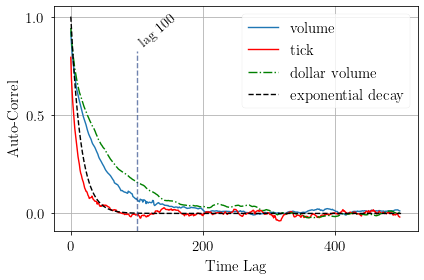

In [165]:
from matplotlib.ticker import AutoMinorLocator
size = 5
plt.params = {'legend.fontsize': '15',
          'figure.figsize': (16, 9),
          'axes.labelsize': size,
          'axes.titlesize': size,
          'xtick.labelsize': size * 0.75,
          'ytick.labelsize': size * 0.75,
          'axes.titlepad': 25}
plt.plot(appended_df_volume.median(axis=1), label ='volume')
plt.plot(appended_df_tick.median(axis=1), color ='r', label ='tick')
plt.plot(appended_df_dollar_volume.median(axis=1), color ='g', linestyle ='dashdot', label ='dollar volume')

N, tau = 1, 15
xlineLevel=100
# Maximum time to consider (s)
tmax = 500
ntau = tmax // tau + 1
# A suitable grid of time points, and the exponential decay itself
t = np.linspace(0, tmax, 400)
y = N * np.exp(-t / tau)

# fig = plt.figure()
# ax = fig.add_subplot(111)
plt.plot(t, y, color='black', linestyle='--', label ='exponential decay')
plt.grid(True)
plt.xlabel("Time Lag", fontsize = 15)
plt.ylabel("Auto-Correl", fontsize = 15)
plt.axvline(x=xlineLevel, ymin=0.0, ymax=0.8, ls='--', alpha=0.7, color='#334f8d')
plt.yticks(fontsize=15)
plt.xticks(fontsize = 15)
plt.text(xlineLevel, 0.85, 'lag ' + str(xlineLevel), rotation=40, fontsize=14)
plt.legend(fontsize = 15, loc =1)
title = str(symbol)+'_auto_correl_clocks.png'
fig_location = os.path.join(figuresLocation , title)
plt.savefig(fig_location)
plt.show()


In [166]:
## Compute the sample average and std
sample_mean_volume = np.mean(appended_df_volume,axis=1)
sample_sd_volume = np.std(appended_df_volume,axis=1)

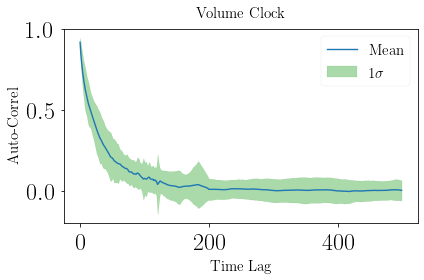

In [167]:
## Plot the sample average and std
plt.plot(range(499),sample_mean_volume,"-",label="Mean")
plt.fill_between(
    range(499),
    sample_mean_volume-sample_sd_volume,
    sample_mean_volume+sample_sd_volume,
    alpha=0.4,
    color="C2",
    edgecolor="none",
    label=r"$1\sigma$")
plt.xlabel("Time Lag", fontsize = 15)
plt.ylabel("Auto-Correl", fontsize = 15)
plt.title('Volume Clock', fontsize = 15)
plt.legend(fontsize = 15)
title = str(symbol)+'_auto_correl_volume_clock_with_bounds.png'
fig_location = os.path.join(figuresLocation , title)
plt.savefig(fig_location)
plt.show()

In [168]:
## Compute the sample average and std - there is a smarter way to do this
sample_mean_tick = np.mean(appended_df_tick,axis=1)
sample_sd_tick = np.std(appended_df_tick,axis=1)

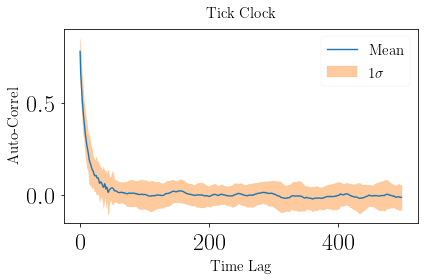

In [169]:
## Plot the sample average and std
plt.plot(range(499),sample_mean_tick,"-",label="Mean")
plt.fill_between(
    range(499),
    sample_mean_tick-sample_sd_tick,
    sample_mean_tick+sample_sd_tick,
    alpha=0.4,
    color="C1",
    edgecolor="none",
    label=r"$1\sigma$")
plt.xlabel("Time Lag", fontsize = 15)
plt.ylabel("Auto-Correl", fontsize = 15)
plt.title('Tick Clock', fontsize = 15)
plt.legend(fontsize = 15)
title = str(symbol)+'_auto_correl_tick_clock_with_bounds.png'
fig_location = os.path.join(figuresLocation , title)
plt.savefig(fig_location)
plt.show()

In [170]:
os.getcwd()

'/home/ak/Documents/PaperCode/stylised_facts/Notebooks'

In [171]:
appended_df_tick

,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,8.208683e-01,0.804206,0.805489,0.769367,0.784240,0.752028,0.722433,0.830863,0.854341,0.825380,0.791438,5.607030e-01,0.791669,0.698132,4.375000e-01,0.746099,0.753550,0.846705,0.769766,0.792646,0.816408,0.814456,0.807615,0.798077,0.792327,0.786212,0.828199,0.764126,0.766994,0.802528,0.853927,0.859450,0.843482,0.786174,0.793648,0.836252,0.769320,0.802314,0.748704,0.802521
1,7.005573e-01,0.700465,0.713761,0.671741,0.670799,0.627657,0.612175,0.733953,0.763522,0.708901,0.669046,2.272502e-01,0.682718,0.578471,5.241935e-02,0.625325,0.663164,0.743309,0.679496,0.680619,0.720240,0.702047,0.700705,0.686732,0.681058,0.670839,0.726296,0.633447,0.654894,0.706174,0.760812,0.766570,0.745490,0.664707,0.676950,0.728153,0.661008,0.712651,0.613090,0.696783
2,6.114270e-01,0.644083,0.656962,0.625278,0.599089,0.545588,0.535611,0.668868,0.691713,0.632366,0.592152,1.255701e-01,0.607913,0.470583,1.735668e-01,0.561343,0.576221,0.683196,0.628133,0.592961,0.644182,0.624459,0.639195,0.600833,0.626528,0.609458,0.661369,0.556978,0.580082,0.659556,0.700137,0.698621,0.672181,0.590870,0.600737,0.660420,0.574044,0.638879,0.536837,0.631328
3,5.406330e-01,0.591167,0.605797,0.571948,0.547565,0.486284,0.474293,0.613556,0.628270,0.581683,0.536789,5.578906e-02,0.562624,0.406436,2.000000e-01,0.492247,0.513651,0.631381,0.575568,0.530874,0.605476,0.571954,0.582188,0.532600,0.588199,0.555985,0.598712,0.488112,0.495550,0.589734,0.647395,0.644219,0.611663,0.527110,0.542690,0.607986,0.522731,0.592536,0.460465,0.564092
4,4.919409e-01,0.539092,0.548922,0.530166,0.501393,0.434745,0.437793,0.560663,0.576008,0.543924,0.490985,-7.750146e-02,0.517301,0.338580,1.263352e-01,0.428111,0.460065,0.587873,0.520715,0.461710,0.559391,0.533382,0.541827,0.475670,0.559589,0.502469,0.551072,0.442140,0.438688,0.540500,0.607230,0.609951,0.562563,0.467649,0.487522,0.562492,0.474957,0.539093,0.425741,0.524319
5,4.431456e-01,0.501919,0.505252,0.472867,0.453822,0.381556,0.391708,0.499142,0.536059,0.506147,0.456354,-8.898388e-02,0.482065,0.292601,4.679803e-02,0.369806,0.411860,0.559358,0.487039,0.428699,0.519408,0.503168,0.509024,0.419412,0.511446,0.468022,0.504558,0.399871,0.392107,0.510921,0.574346,0.571728,0.513908,0.411741,0.425679,0.520414,0.435489,0.495353,0.359824,0.481066
6,3.830975e-01,0.469994,0.472907,0.425182,0.406202,0.329454,0.350056,0.454774,0.497210,0.464821,0.428104,8.844477e-02,0.442127,0.252068,7.283570e-02,0.331113,0.366409,0.525813,0.451101,0.383961,0.484306,0.467341,0.467086,0.387254,0.487661,0.436008,0.467285,0.369805,0.344176,0.477855,0.549065,0.538320,0.476230,0.357241,0.381783,0.488820,0.401368,0.464018,0.299820,0.429161
7,3.489630e-01,0.430993,0.444326,0.391005,0.376900,0.286258,0.313481,0.416519,0.467320,0.422297,0.403037,1.398030e-02,0.406835,0.209672,-4.852616e-02,0.286475,0.327177,0.497256,0.420656,0.330970,0.456542,0.429321,0.431944,0.359336,0.466224,0.402382,0.419549,0.339057,0.298165,0.438827,0.510189,0.507529,0.438983,0.299805,0.347419,0.446027,0.371995,0.417570,0.242749,0.386709
8,3.184791e-01,0.407818,0.408150,0.359586,0.353766,0.265861,0.276883,0.381926,0.432922,0.388548,0.381156,6.674018e-02,0.374635,0.158087,-1.734552e-01,0.243759,0.278849,0.457778,0.395817,0.281445,0.422625,0.403232,0.390696,0.324293,0.434995,0.365549,0.382220,0.315070,0.268900,0.423909,0.478598,0.479357,0.400356,0.266956,0.315934,0.419976,0.326498,0.391512,0.203559,0.339883
9,2.730165e-01,0.384621,0.364370,0.324247,0.314951,0.237624,0.251754,0.363289,0.399628,0.352967,0.343219,1.859597e-01,0.353331,0.121107,-2.357023e-01,0.206910,0.230477,0.429175,0.370956,0.250600,0.402189,0.384123,0.364616,0.298469,0.413506,0.338262,0.358249,0.285820,0.238990,0.397887,0.453632,0.452051,0.372247,0.239880,0.281518,0.376480,0.301243,0.376111,0.185263,0.302525


In [172]:
import numpy as np
import matplotlib.pyplot as plt
import freqopttest.util as util
import freqopttest.data as data
import freqopttest.kernel as kernel
import freqopttest.tst as tst

ModuleNotFoundError: No module named 'freqopttest'